# Quantum agents in the Gym: a variational quantum algorithm for deep Q-learning

In this tutorial, we implement a variational quantum algorithm for deep Q-learning as introduced in [1] with TensorFlow Quantum [2]. 

The code in this notebook is based on a TensorFlow Quantum tutorial written by Sofiene Jerbi (coming soon).

In [ ]:
!pip install tensorflow==2.3.1
!pip install tensorflow_quantum
!pip install sympy
!pip install cirq
!pip install gym

In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt
import sympy
import random
import cirq
import numpy as np
import gym
from functools import reduce
from collections import deque
from collections import namedtuple
from cirq.contrib.svg import SVGCircuit

Our quantum model will use *data re-uploading* [3, 4] and trainable weights on the input angles [3, 5] that we use to encode the environment state into the PQC. In general, TFQ expects us to pass input data in form of circuits which are fed into the first layer of a PQC model. For data re-uploading, we want to repeat the input data in every layer of our PQC. We accomplish this by using a ControlledPQC layer instead. However, the ControlledPQC expects us to take care of *all* trainable paramters of the model. We implement a custom layer that does this, called *ScalableDataReuploadingController*.



In [3]:
class ScalableDataReuploadingController(tf.keras.layers.Layer):
    """
    Stores all the variational parameters of the PQC, except for the observable weights,
        i.e., angles theta for variational gates and rescaling parameters lmbd for encoding gates.
    Performs the tansformation (x_1, ..., x_d) -> (theta_1, ..., theta_N, lmbd[1][1]x_1, ..., lmbd[1][M]x_1,
        ......., lmbd[d][1]x_d, ..., lmbd[d][M]x_d) for d=input_dim, N=theta_dim and M=encoding_dim
    These are finally permuted such as to follow the alphabetical order of their names (provided in angles),
        as processed at the input of the ControlledPQC
    """
    def __init__(self, input_dim, theta_dim, encoding_dim, angles, tanh=False, name="scalable_data_reuploading"):
        super(ScalableDataReuploadingController, self).__init__(name=name)
        self.input_dim = input_dim # dimension of input vector
        self.theta_dim = theta_dim # dimension of variational params vector
        self.encoding_dim = encoding_dim # number of repetitions of encoding

        # PQC parameters
        theta_init = tf.random_uniform_initializer(minval=0., maxval=np.pi)
        self.theta = tf.Variable(
            initial_value=theta_init(shape=(1, theta_dim), dtype=tf.dtypes.float32),
            trainable=True, name="thetas"
        )

        # trainable weights on input variables
        lmbd_init = tf.ones(shape=(1, input_dim*encoding_dim))
        self.lmbd = tf.Variable(
            initial_value=lmbd_init, dtype=tf.dtypes.float32,
            trainable=True, name="lambdas"
        )

        alphabetical_angles = sorted(angles)
        # re-ordering of indices to match order of expectation_layer.symbols
        self.indices = tf.constant([alphabetical_angles.index(a) for a in angles])
        self.tanh = tanh # apply an activation on the encoding angles

    def call(self, inputs):
        output = tf.repeat(self.theta,repeats=tf.shape(inputs)[0],axis=0)
        repeat_inputs = tf.repeat(inputs,repeats=self.encoding_dim,axis=1)
        repeat_lmbd = tf.repeat(self.lmbd,repeats=tf.shape(inputs)[0],axis=0)

        if self.tanh:
            output = tf.concat([output, tf.keras.layers.Activation('tanh')(tf.math.multiply(repeat_inputs, repeat_lmbd))], 1)
        else:
            output = tf.concat([output, tf.math.multiply(repeat_inputs, repeat_lmbd)], 1)
        output = tf.gather(output, self.indices, axis=1) # re-ordering of indices to match order of expectation_layer.symbols
        return output

Now we create functions that generate a PQC with a hardware-efficient architecture with a circular connectivity. The PQC also includes our data encoding gates, which are local X-rotations on each qubit.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


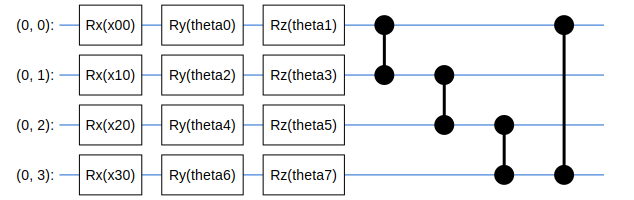

In [4]:
def hwe_layer(qubits, symbols, layer):
    """
    Returns a Cirq circuit for a hardware efficient layer with ring topology.
    """
    circuit = cirq.Circuit()
    symbols = list(symbols)[::-1]

    for i, qubit in enumerate(qubits):
        circuit.append(cirq.ry(symbols.pop())(qubit))
        circuit.append(cirq.rz(symbols.pop())(qubit))
    
    for i in range(len(qubits)):
        circuit.append(cirq.CZ(qubits[i], qubits[(i + 1) % len(qubits)]))

    return circuit


def generate_circuit(n, L, qubits):
    """
    Takes as input a number of qubits n, a number of layers L, and the qubits of the circuit.
    Returns a cirq circuit, the number of variational parameters, and the sympy symbols
    of variational and data encoding angles.
    """
    # Number of variational angles
    theta_dim = 2 * n * L

    # Sympy symbols for variational and data encoding angles
    params = sympy.symbols('theta(0:' + str(theta_dim) + ')')
    inputs = sympy.symbols(
        'x(0:' + str(n) + ')' + '(0:' + str(L) + ')')

    # Define circuit
    circuit = cirq.Circuit()
    for l in range(L):
        # Data encoding layer
        for i in range(n):
            circuit += cirq.rx(inputs[l + i * L])(qubits[i])
        # Variational layer
        circuit += hwe_layer(qubits, params[l*n*2:(l+1)*n*2], l)

    return circuit, theta_dim, params, inputs

circuit, theta_dim, params, inputs = generate_circuit(4, 1, [cirq.GridQubit(0, i) for i in range(4)])
SVGCircuit(circuit)

We use Z-basis measurements to read out Q-values, which produce expectation values in [-1, 1]. To enable a flexible range of Q-values that matches the environment at hand, we scale the expectation values to [0, 1] and multiply them with a trainbale weight for each available action. This is done by the following *TrainableRescaling* layer:

In [5]:
class TrainableRescaling(tf.keras.layers.Layer):
    def __init__(self, input_dim):
        super(TrainableRescaling, self).__init__()
        self.input_dim = input_dim
        self.w = tf.Variable(
            initial_value=tf.ones(shape=(1,input_dim)), dtype=tf.dtypes.float32,
            trainable=True, name="obs-weights")

    def call(self, inputs):
        # scale expectation values to [0, 1] and multiply with weights
        return tf.math.multiply((inputs+1)/2, tf.repeat(self.w, repeats=tf.shape(inputs)[0], axis=0))

Now we only need to generate the model before we can start learning:

In [6]:
# dummy input for TFQ model
def empty_circuits(n):
    return tfq.convert_to_tensor([cirq.Circuit()]*n)

def generate_model(n, L, circuit, theta_dim, params, inputs, observables, target):
    """
    Takes as input a number of qubits n, a number of layers L, a Cirq circuit, a number of variational angles,
    sympy symbols of variational and encoding angles, the observables to be used at the ouput of the PQC,
    and a boolean specifying if the generated model is a target model or main model.
    Returns the generated model of the PQC Q-function approximator.
    """
    # Define input tensor
    input_tensor = tf.keras.Input(shape=(n), dtype=tf.dtypes.float32, name='input')

    # Define input quantum state
    input_q_state = tf.keras.Input(shape=(), dtype=tf.string, name='quantum_state')

    # Define encoding layer
    encoding_layer = ScalableDataReuploadingController(
        input_dim=n, theta_dim=theta_dim, encoding_dim=L,
        angles=[str(param) for param in params] + [str(x) for x in inputs], tanh=True)

    # Define Controlled PQC
    expectation_layer = tfq.layers.ControlledPQC(
        circuit, differentiator=tfq.differentiators.ForwardDifference(),
        operators=observables, name="PQC")

    prepend = ""
    if target:
        prepend = "Target"

    # Define post-processing
    expectation_values = expectation_layer(
        [input_q_state, encoding_layer(input_tensor)])
    
    process = tf.keras.Sequential([
        TrainableRescaling(len(observables))
    ], name=prepend + "Q-values")

    Q_values = process(expectation_values)

    # Define model
    model = tf.keras.Model(
        inputs=[input_q_state, input_tensor],
        outputs=Q_values, 
        name=prepend + "Q-function")

    return model


Set up model and environment, then start training:

Episode 1/2500, rewards 17.0
Instructions for updating:
Use fn_output_signature instead
Episode 2/2500, rewards 21.0
Episode 3/2500, rewards 23.0
Episode 4/2500, rewards 15.0
Episode 5/2500, rewards 19.0
Episode 6/2500, rewards 17.0
Episode 7/2500, rewards 14.0
Episode 8/2500, rewards 16.0
Episode 9/2500, rewards 13.0
Episode 10/2500, rewards 21.0
Episode 11/2500, rewards 18.0
Episode 12/2500, rewards 22.0
Episode 13/2500, rewards 22.0
Episode 14/2500, rewards 16.0
Episode 15/2500, rewards 20.0
Episode 16/2500, rewards 26.0
Episode 17/2500, rewards 17.0
Episode 18/2500, rewards 15.0
Episode 19/2500, rewards 57.0
Episode 20/2500, rewards 12.0
Episode 21/2500, rewards 16.0
Episode 22/2500, rewards 11.0
Episode 23/2500, rewards 10.0
Episode 24/2500, rewards 11.0
Episode 25/2500, rewards 9.0
Episode 26/2500, rewards 11.0
Episode 27/2500, rewards 9.0
Episode 28/2500, rewards 15.0
Episode 29/2500, rewards 10.0
Episode 30/2500, rewards 12.0
Episode 31/2500, rewards 20.0
Episode 32/2500, rewar

Text(0.5, 0, 'Episode')

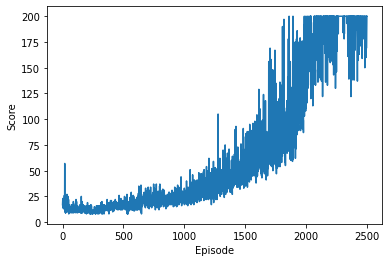

In [7]:
# Define model hyperparameters, generate model set up environment

n = 4 # Dimension of the state vectors in CartPole
L = 5 # Number of layers in the PQC
nb_actions = 2 # Number of actions in CartPole

qubits = [cirq.GridQubit(i,0) for i in range(n)]
circuit, theta_dim, params, inputs = generate_circuit(n, L, qubits)
ops = [cirq.Z(qubits[i]) for i in range(n)]
observables = [ops[0]*ops[1], ops[2]*ops[3]] # Z_0*Z_1 for action 0 and Z_2*Z_3 for action 1

model = generate_model(n, L, circuit, theta_dim, params, inputs, observables, False)
model_target = generate_model(
    n, L, circuit, theta_dim, params, inputs, observables, True)
model_target.set_weights(model.get_weights())

env = gym.make("CartPole-v0")
gamma = 0.99
nb_episodes = 2500

interaction = namedtuple('interaction', ('state', 'action', 'reward', 'next_state', 'done'))

# Define replay memory
max_memory_length = 10000  # Maximum replay length
replay_memory = deque(maxlen=max_memory_length)

epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.01  # Minimum epsilon greedy parameter
decay_epsilon = 0.99  # Decay rate of epsilon greedy parameter
batch_size = 16
# Train the model every update_VQC steps
update_VQC = 10
# Update the target model every update_target steps
update_target = 30

# Prepare loss function
loss_function = tf.keras.losses.Huber()

# Prepare optimizers
optimizer_input = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
optimizer_var = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
optimizer_output = tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True)
w_input, w_var, w_output = 1, 0, 2
if ('lambdas' not in model.trainable_variables[w_input].name) or (
    'thetas' not in model.trainable_variables[w_var].name) or (
    'obs-weights' not in model.trainable_variables[w_output].name):
    raise ValueError("Wrong indexing of optimizers parameters.")

episode_reward_history = []

step_count = 0
for episode in range(nb_episodes):
    episode_reward = 0
    state = env.reset()

    while True:
        # Increase step count
        step_count += 1

        # Preprocess state
        state_array = np.array(state)
        state = tf.convert_to_tensor(state_array)
        state = tf.expand_dims(state, 0)

        # Sample action
        if random.random() > epsilon:
            q_vals = model([empty_circuits(1), state])
            action = int(tf.argmax(q_vals[0]).numpy())
        else:
            action = np.random.choice(nb_actions)

        # Apply sampled action in the environment, receive reward and next state
        next_state, reward, done, _ = env.step(action)

        # Store last interaction in the replay memory
        sarsd = interaction(
            np.copy(state_array), action, reward, np.copy(next_state), float(done))
        replay_memory.append(sarsd)

        state = np.array(next_state)
        episode_reward += reward

        # Update model
        if step_count % update_VQC == 0 and len(replay_memory) >= batch_size:
            # Sample a batch of interactions
            batch = random.choices(replay_memory, k=batch_size)
            batch = interaction(*zip(*batch))

            # Compute their target q_values and the masks on sampled actions
            future_rewards = model_target.predict(
                [empty_circuits(batch_size), tf.constant(batch.next_state)])
            target_q_values = tf.constant(batch.reward) + gamma * tf.reduce_max(future_rewards, axis=1) * (
            1 - tf.constant(batch.done))
            masks = tf.one_hot(batch.action, nb_actions)

            # Train the model on the states and target Q-values
            with tf.GradientTape() as tape:
                q_values = model([empty_circuits(batch_size), tf.constant(batch.state)])
                # Apply the masks to the Q-values
                q_values_masked = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between target Q-values and model Q-values
                loss = loss_function(target_q_values, q_values_masked)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer_input.apply_gradients([(grads[w_input], model.trainable_variables[w_input])])
            optimizer_var.apply_gradients([(grads[w_var], model.trainable_variables[w_var])])
            optimizer_output.apply_gradients([(grads[w_output], model.trainable_variables[w_output])])

        # Update target model
        if episode % update_target == 0:
            model_target.set_weights(model.get_weights())

        # Check if episode ended
        if done:
            break
    
    # Decay epsilon
    epsilon = max(epsilon * decay_epsilon, epsilon_min)
    episode_reward_history.append(episode_reward)
    print("Episode {}/{}, rewards {}".format(episode + 1, nb_episodes, episode_reward))

plt.plot(episode_reward_history)
plt.ylabel("Score")
plt.xlabel("Episode")

# References

[1] Skolik, Andrea, Sofiene Jerbi, and Vedran Dunjko. "Quantum agents in the Gym: a variational quantum algorithm for deep Q-learning." arXiv preprint arXiv:2103.15084 (2021).

[2] Broughton, Michael, et al. "Tensorflow quantum: A software framework for quantum machine learning." arXiv preprint arXiv:2003.02989 (2020).

[3] Pérez-Salinas, Adrián, et al. "Data re-uploading for a universal quantum classifier." Quantum 4 (2020): 226.

[4] Schuld, Maria, Ryan Sweke, and Johannes Jakob Meyer. "Effect of data encoding on the expressive power of variational quantum-machine-learning models." Physical Review A 103.3 (2021): 032430.

[5] Jerbi, Sofiene, et al. "Variational quantum policies for reinforcement learning." arXiv preprint arXiv:2103.05577 (2021).